# Sentiment Classification with Transformer

We implement a transformer-based Sentiment Classifier for the imdb movie reviews dataset.

## Dependencies and Parameters

In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.datasets import imdb
from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## checking tf version
print(tf.__version__)

2.9.2


In [6]:
# Define the parameters
VOCAB_SIZE = 10000 #88584 #this is length of the word2id dictionary
EMBEDDING_SIZE = 32
HIDDEN_DIM = 200
NUM_LAYERS = 1
NUM_HEADS = 2
MAX_LEN = 500
NUM_SAMPLES = 500
TEST_SIZE = round(0.15 * NUM_SAMPLES)
NUM_EPOCH = 10
CALLBACK = True

In [ ]:
SAVE_PATH = f"/content/drive/MyDrive/models/keras-transformer-{EMBEDDING_SIZE}-{HIDDEN_DIM}-{NUM_LAYERS}-{MAX_LEN}-{NUM_SAMPLES}-{NUM_EPOCH}-{VOCAB_SIZE}"
LOGDIR = SAVE_PATH + '/logs/'

print(SAVE_PATH)

/content/drive/MyDrive/models/keras-transformer-32-200-1-500-25000-10-10000


In [ ]:
!mkdir $SAVE_PATH

## Loading and Preprocessing the Data

In [7]:
vocabulary_size = VOCAB_SIZE
start_char = 1
oov_char = 2
index_from = 3

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size, start_char=start_char, oov_char=oov_char, index_from=index_from)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

17464789/17464789 [==============================] - 0s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


In [8]:
# inspect sample
print('---review---')
print(X_train[0])
print('---label---')
print(y_train[0])

---review---
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
---label---
1


In [9]:
word2id = imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word2id.items()
)
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
print(len(inverted_word_index)) # total number of words

print('---review with words---')
print([inverted_word_index.get(i, ' ') for i in X_train[0]])
print('---label---')
print(y_train[0])

1641221/1641221 [==============================] - 0s 0us/step
88586
---review with words---
['[START]', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', '[OOV]', 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', '[OOV]', 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', '[OOV]', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'fishing', 'was', 'amazing', 'really', 'cried', 'at', 'the', 'end', 

In [ ]:
# max and min length review
print('Maximum review length: {}'.format(
len(max((X_train + X_test), key=len))))
print('Minimum review length: {}'.format(
len(min((X_test + X_test), key=len))))
print(len(word2id))

Maximum review length: 2697
Minimum review length: 14
88584


In [ ]:
from keras_preprocessing.sequence import pad_sequences

max_words = MAX_LEN
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [ ]:
# batch_size = 64
test_size = TEST_SIZE
num_epochs = NUM_EPOCH
samples = NUM_SAMPLES

X_test, y_test = X_test[:test_size], y_test[:test_size]
X_train2, y_train2 = X_train[:samples], y_train[:samples]

## Define Classifier Architecture

### Transformer Block

In [ ]:
# source:(https://keras.io/examples/nlp/text_classification_with_transformer/)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

### Embedding and Position

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb
        })
        return config

### Create Model Instance

In [ ]:
embed_dim = EMBEDDING_SIZE # 32 # Embedding size for each token
num_heads = NUM_HEADS # 2 # Number of attention heads
ff_dim = HIDDEN_DIM # 200  # Hidden layer size in feed forward network inside transformer
maxlen = MAX_LEN
vocab_size = VOCAB_SIZE

## Using Sequential API
model = keras.Sequential()
model.add(layers.Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  (None, 500, 32)          336000    
 g_9 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_9 (Transf  (None, 500, 32)          21576     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_9   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 200)             

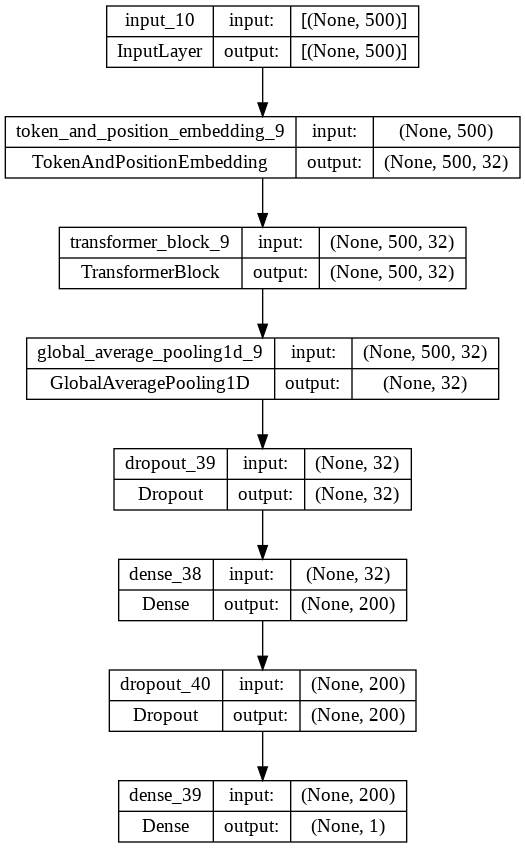

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
  def __init__(self):
    self.train_batch = []
    self.train_losses = {}
    self.test_batch = []
    self.test_losses = {}
    self.test_accuracy_batch = []
    self.test_accuracy = {}
    self.train_accuracy_batch = []
    self.train_accuracy = {}
  def on_train_batch_end(self, batch, logs=None):
    self.train_batch.append(logs["loss"])
    self.train_accuracy_batch.append(logs["accuracy"])
    # print(
    #     "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    # )

  def on_test_batch_end(self, batch, logs=None):
    self.test_batch.append(logs["loss"])
    self.test_accuracy_batch.append(logs["accuracy"])
    # print(
    #     "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
    # )

  def on_epoch_end(self, epoch, logs=None):
    self.train_losses[epoch] = self.train_batch
    self.test_losses[epoch] = self.test_batch
    self.train_accuracy[epoch] = self.train_accuracy_batch
    self.test_accuracy[epoch] = self.test_accuracy_batch
    self.train_batch = []
    self.test_batch = []
    self.train_accuracy_batch = []
    self.test_accuracy_batch = []
    print("The average loss for epoch {} is {:7.2f} ".format(epoch, logs["loss"]))

loss_and_error = LossAndErrorPrintingCallback()

In [ ]:
import time

class TimeCallback(keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.time()
        self.batch_times = {}
        self.epoch_times = {}
        self.total_time = time.time()
    def on_train_batch_end(self, batch, logs=None):
      self.times.append(time.time() - self.timetaken)
      self.timetaken = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.batch_times[epoch] = self.times
        self.epoch_times[epoch] = sum(self.times)

        print(f"it took {(epoch,time.time() - self.timetaken)} time")

        #reset variables
        self.times = []
        self.timetaken = time.time()

    def on_train_end(self,logs={}):
      self.total_time = time.time() - self.total_time
    # def on_train_end(self,logs = {}):
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Total time taken until an epoch in seconds')
    #     plt.plot(*zip(*self.times))
    #     plt.show()

time_callback = TimeCallback()

In [ ]:
from datetime import datetime
import tensorflow as tf

callbacks = []
logdir = LOGDIR

if CALLBACK:

  my_callbacks = [
      # tf.keras.callbacks.EarlyStopping(patience=2),
      tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
      tf.keras.callbacks.TensorBoard(log_dir=logdir),
      tf.keras.callbacks.CSVLogger(logdir + 'logs.csv', append=True, separator=','),
      time_callback,
      loss_and_error
  ]


In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    X_train2, 
    y_train2, 
    validation_data=(X_test, y_test), 
    batch_size=64, 
    epochs=NUM_EPOCH,
    callbacks=my_callbacks
)

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.7757it took (0, 41.37757992744446) time
The average loss for epoch 0 is    0.43 
391/391 [==============================] - 476s 1s/step - loss: 0.4329 - accuracy: 0.7757 - val_loss: 0.3867 - val_accuracy: 0.8115
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9085it took (1, 41.047038316726685) time
The average loss for epoch 1 is    0.23 
391/391 [==============================] - 459s 1s/step - loss: 0.2337 - accuracy: 0.9085 - val_loss: 0.2702 - val_accuracy: 0.8867
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9374it took (2, 41.04204440116882) time
The average loss for epoch 2 is    0.17 
391/391 [==============================] - 462s 1s/step - loss: 0.1702 - accuracy: 0.9374 - val_loss: 0.3134 - val_accuracy: 0.8779
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.1370 - accuracy

# Save and Evaluate

In [ ]:
# evaluate 
print(history.history)
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

{'loss': [0.432918906211853, 0.233682319521904, 0.1701626181602478, 0.13696306943893433, 0.10919295251369476, 0.08840619772672653, 0.0727863609790802, 0.06656960397958755, 0.05339482054114342, 0.045869745314121246], 'accuracy': [0.7757200002670288, 0.908519983291626, 0.9374399781227112, 0.9520800113677979, 0.9642000198364258, 0.972599983215332, 0.9781200289726257, 0.9796800017356873, 0.98444002866745, 0.9878000020980835], 'val_loss': [0.38674360513687134, 0.2702326774597168, 0.31343355774879456, 0.34981679916381836, 0.3894530236721039, 0.45992782711982727, 0.5313953757286072, 0.5266337394714355, 0.5045926570892334, 0.6004998683929443], 'val_accuracy': [0.8114666938781738, 0.8866666555404663, 0.8778666853904724, 0.8762666583061218, 0.8672000169754028, 0.8669333457946777, 0.8541333079338074, 0.8565333485603333, 0.8581333160400391, 0.8573333621025085]}
Test accuracy: 0.8573333621025085


In [ ]:
print(f'Total time = {time_callback.total_time}')

Total time = 4569.508405447006


In [ ]:
# save the model
MODEL_PATH = SAVE_PATH + '/model'
model.save(MODEL_PATH)

# Load the model

In [ ]:
# loading the saved model
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
new_model = keras.models.load_model(MODEL_PATH)

In [ ]:
# testing on random inputs
inputs = ["i hate this movie", "this sucks", "i never want to watch this again"]
seqs = [[word2id[i] for i in inp.split(' ')] for inp in inputs ]
print(seqs)
output_bad = new_model(tf.constant(pad_sequences(seqs, maxlen=max_words), dtype=np.float32))
print(output_bad)

[[10, 781, 11, 17], [11, 1867], [10, 112, 178, 5, 103, 11, 171]]
tf.Tensor(
[[0.15112773]
 [0.3718978 ]
 [0.3592092 ]], shape=(3, 1), dtype=float32)


## Ploting Training Results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

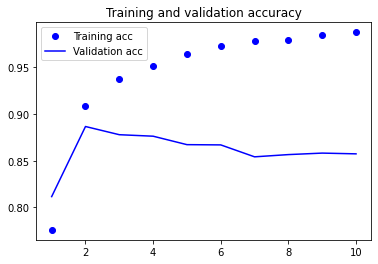

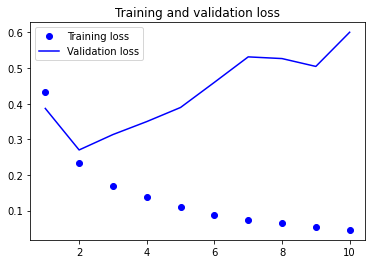

In [ ]:
plot1(history)

# Save info in callbacks

In [ ]:
# remove current logs if exists
import os
for file in ['train_losses_per_batch.csv', 'test_losses_per_batch.csv', 'time_per_epoch.csv', 'time_per_batch.csv', 'log.csv']:
  try:
    os.remove(file)
  except:
    continue

In [ ]:
# save training and test loss per epoch
import csv

filename = SAVE_PATH + '/train_losses_per_batch.csv'
with open(filename, 'w') as f:
  writer = csv.DictWriter(f, fieldnames=["Epoch", "Training Loss"])
  writer.writeheader()
  for epoch in loss_and_error.train_losses.keys():
    for loss in loss_and_error.train_losses[epoch]:
      data = {"Epoch": epoch, "Training Loss": loss}
      writer.writerow(data)

filename = SAVE_PATH + '/test_losses_per_batch.csv'
with open(filename, 'w') as f:
  writer = csv.DictWriter(f, fieldnames=["Epoch", "Test Loss"])
  writer.writeheader()
  for epoch in loss_and_error.test_losses.keys():
    for loss in loss_and_error.test_losses[epoch]:
      data = {"Epoch": epoch, "Test Loss": loss}
      writer.writerow(data)

filename = SAVE_PATH + '/train_accuracy_per_batch.csv'
with open(filename, 'w') as f:
  writer = csv.DictWriter(f, fieldnames=["Epoch", "Train Accuracy"])
  writer.writeheader()
  for epoch in loss_and_error.train_accuracy.keys():
    for loss in loss_and_error.train_accuracy[epoch]:
      data = {"Epoch": epoch, "Train Accuracy": loss}
      writer.writerow(data)

filename = SAVE_PATH + '/test_accuracy_per_batch.csv'
with open(filename, 'w') as f:
  writer = csv.DictWriter(f, fieldnames=["Epoch", "Test Accuracy"])
  writer.writeheader()
  for epoch in loss_and_error.test_accuracy.keys():
    for loss in loss_and_error.test_accuracy[epoch]:
      data = {"Epoch": epoch, "Test Accuracy": loss}
      writer.writerow(data)

print(loss_and_error.test_losses)

{0: [0.35197943449020386, 0.3728649318218231, 0.36435770988464355, 0.37096133828163147, 0.36867576837539673, 0.38764214515686035, 0.3907804787158966, 0.3897903263568878, 0.39834171533584595, 0.38955146074295044, 0.38211002945899963, 0.38483095169067383, 0.37537261843681335, 0.37679943442344666, 0.37335148453712463, 0.3755370080471039, 0.37009644508361816, 0.3724622130393982, 0.3744722306728363, 0.37480664253234863, 0.37890511751174927, 0.3805227279663086, 0.37694594264030457, 0.3741362392902374, 0.3721584677696228, 0.3750157654285431, 0.37671226263046265, 0.3772931396961212, 0.37701451778411865, 0.3804534375667572, 0.383865088224411, 0.3824458122253418, 0.37946754693984985, 0.3785865604877472, 0.3816964626312256, 0.38126465678215027, 0.3813583254814148, 0.3795764148235321, 0.3802762031555176, 0.3833680748939514, 0.3839455246925354, 0.38365477323532104, 0.386038213968277, 0.3857402503490448, 0.3841181993484497, 0.38300517201423645, 0.38233286142349243, 0.381841778755188, 0.3840435445308

In [ ]:
# save the time
file1 = SAVE_PATH + '/time_per_epoch.csv'
file2 = SAVE_PATH + '/time_per_batch.csv'
try:
    with open(file1, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=time_callback.epoch_times.keys())
        writer.writeheader()
        for data in [time_callback.epoch_times]:
            writer.writerow(data)
    with open(file2, 'w') as f:
      writer = csv.DictWriter(f, fieldnames=["Epoch", "Batch", "Time"])
      writer.writeheader()
      for epoch in time_callback.batch_times.keys():
        for batch, time in enumerate(time_callback.batch_times[epoch]):
          data = {"Epoch": epoch, "Batch": batch, "Time": time}
          writer.writerow(data)
except IOError:
    print("I/O error")

print(time_callback.epoch_times)

{0: 434.69236397743225, 1: 417.6374251842499, 2: 421.3521478176117, 3: 421.03095030784607, 4: 421.2688925266266, 5: 411.0338668823242, 6: 411.27419257164, 7: 410.12713599205017, 8: 412.1000587940216, 9: 413.3676931858063}


## References

We implemented this as an adaption of [Sentiment Classification with Transformer on the NLTK movie reviews dataset](https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/dl-transformers-keras.html)